In [129]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pycaret.time_series import TSForecastingExperiment

### Load and preprocess data

In [130]:
def loadAndPreprocessData(filePath, targetColumns):
    data = pd.read_csv(filePath)
    data['Date_Time'] = pd.to_datetime(data['Date_Time'])
    data = data.sort_values(by='Date_Time').reset_index(drop=True)
    
    data['Date'] = data['Date_Time'].dt.date
    dailyData = data.groupby('Date').agg({
        col: 'mean' for col in targetColumns
    }).reset_index()

    dailyData['Date'] = pd.to_datetime(dailyData['Date'])
    dailyData = dailyData.set_index('Date').asfreq('D')
    dailyData = dailyData.interpolate(method='time') 
    
    return dailyData

### Splitting the data into training & testing 

In [131]:
def splitData(data, targetColumn, splitRatio=0.8):
    splitIndex = int(len(data) * splitRatio)
    trainData = data.iloc[:splitIndex][[targetColumn]].copy()
    testData = data.iloc[splitIndex:][[targetColumn]].copy()
    return trainData, testData

### Train Forecasting Models

In [132]:
def setupPycaretExperiment(trainData, targetColumn):
    exp = TSForecastingExperiment()
    exp.setup(
        data=trainData,
        target=targetColumn,
        numeric_imputation_target='mean',
        session_id=123
    )
    return exp

In [133]:
def trainAndEvaluateModels(exp, forecastHorizon, testData, label):
    models = ['arima', 'naive', 'et_cds_dt', 'grand_means', 'croston']
    forecasts = {}
    
    for model in models:
        print(f"Training {model}...")
        trainedModel = exp.create_model(model)
        forecast = exp.predict_model(trainedModel, fh=forecastHorizon)
        forecasts[model] = forecast
        
        plotForecastsVsActual(
            testData.index, 
            testData[label], 
            forecast, 
            model.upper(), 
            label
        )
    
    return forecasts

### Printing evaluation metrics

In [134]:
def evaluateForecast(exp, model, forecastHorizon):
    forecast = exp.predict_model(model, fh=forecastHorizon)
    return forecast

### Plotting actual vs forecasted values

In [ ]:
def trainAndEvaluateModels(exp, forecastHorizon, testData, label, minValue, maxValue):
    models = ['arima', 'naive', 'et_cds_dt']
    forecasts = {}
    
    plt.figure(figsize=(12, 6))
    
    plt.plot(
        testData.index, 
        testData[label], 
        marker='o', 
        linestyle='-', 
        label=f'Actual {label}', 
        linewidth=3, 
        alpha=0.8  
    )

    lineStyles = ['-', '--', '-.', ':']
    colors = ['blue', 'orange', 'green', 'purple', 'brown']
    
    for i, model in enumerate(models):
        print(f"Training {model}...")
        trainedModel = exp.create_model(model)
        forecast = exp.predict_model(trainedModel, fh=forecastHorizon)
        forecasts[model] = forecast
        
        plt.plot(
            testData.index, 
            forecast, 
            marker='o', 
            linestyle=lineStyles[i % len(lineStyles)], 
            label=f'{model.upper()} Forecast', 
            linewidth=3, 
            alpha=0.9,  
            color=colors[i % len(colors)]
        )

    plt.axhline(
        y=minValue, 
        color='red', 
        linestyle='--', 
        linewidth=1.5, 
        label=f'Min {label}: {minValue:.2f}'
    )
    plt.axhline(
        y=maxValue, 
        color='green', 
        linestyle='--', 
        linewidth=1.5, 
        label=f'Max {label}: {maxValue:.2f}'
    )

    plt.title(f'Actual vs Forecasted {label} for All Models')
    plt.xlabel('Date')
    plt.ylabel(label)
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return forecasts


In [136]:
def runForecastPipeline(filePath, targetColumn, label, forecastHorizonRatio=0.2, minValue=None, maxValue=None):
    data = loadAndPreprocessData(filePath, targetColumns=[targetColumn])
    trainData, testData = splitData(data, targetColumn, splitRatio=1 - forecastHorizonRatio)
    forecastHorizon = list(range(1, len(testData) + 1))
    
    exp = setupPycaretExperiment(trainData, targetColumn)
    forecasts = trainAndEvaluateModels(exp, forecastHorizon, testData, targetColumn, minValue, maxValue)
    
    return forecasts

,Description,Value
0,session_id,123
1,Target,Temperature_C
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(111, 1)"
5,Transformed data shape,"(111, 1)"
6,Transformed train set shape,"(110, 1)"
7,Transformed test set shape,"(1, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


Training arima...


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE
0,2024-04-16,0.0160,0.0131,0.0037,0.0037,0.0002,0.0002
1,2024-04-17,0.0131,0.0108,0.0030,0.0030,0.0002,0.0002
2,2024-04-18,0.1168,0.0960,0.0268,0.0268,0.0018,0.0018
Mean,NaT,0.0486,0.0400,0.0112,0.0112,0.0008,0.0008
SD,NaT,0.0482,0.0396,0.0111,0.0111,0.0007,0.0007


Training naive...


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE
0,2024-04-16,0.6702,0.5511,0.1553,0.1553,0.0104,0.0103
1,2024-04-17,0.4304,0.3540,0.0994,0.0994,0.0067,0.0067
2,2024-04-18,0.3824,0.3141,0.0878,0.0878,0.0059,0.0059
Mean,NaT,0.4943,0.4064,0.1142,0.1142,0.0077,0.0076
SD,NaT,0.1259,0.1036,0.0294,0.0294,0.0019,0.0019


Training et_cds_dt...


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE
0,2024-04-16,0.2266,0.1863,0.0525,0.0525,0.0035,0.0035
1,2024-04-17,0.0152,0.0125,0.0035,0.0035,0.0002,0.0002
2,2024-04-18,1.7210,1.4137,0.3954,0.3954,0.0267,0.0264
Mean,NaT,0.6543,0.5375,0.1505,0.1505,0.0102,0.0100
SD,NaT,0.7592,0.6236,0.1743,0.1743,0.0118,0.0116


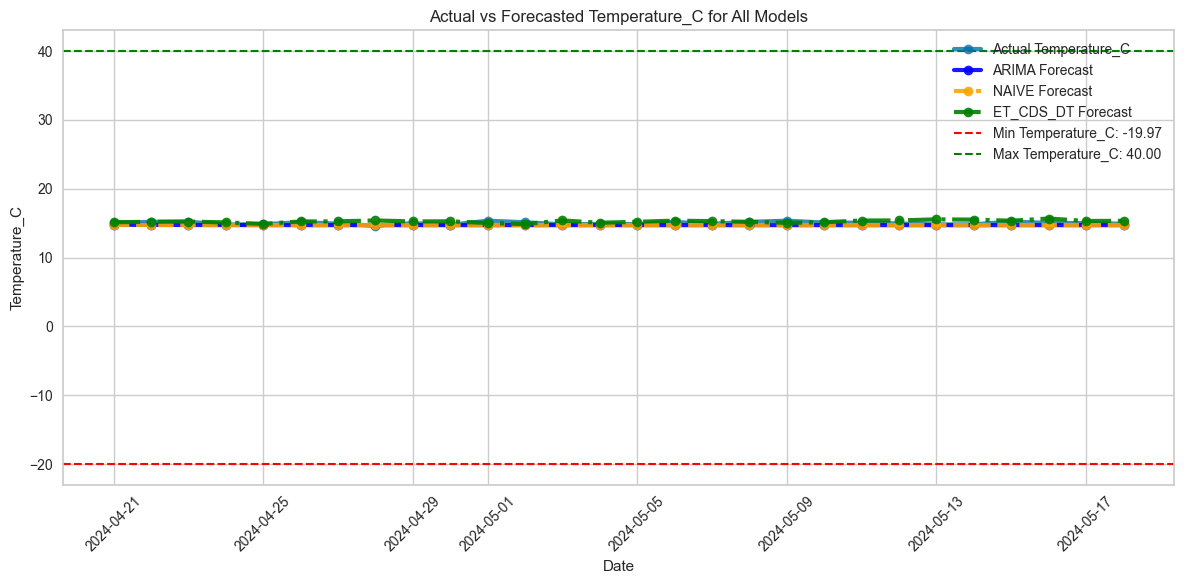

,Description,Value
0,session_id,123
1,Target,Humidity_pct
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(111, 1)"
5,Transformed data shape,"(111, 1)"
6,Transformed train set shape,"(110, 1)"
7,Transformed test set shape,"(1, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


Training arima...


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE
0,2024-04-16,0.0625,0.0484,0.0131,0.0131,0.0002,0.0002
1,2024-04-17,0.0597,0.0464,0.0125,0.0125,0.0002,0.0002
2,2024-04-18,1.1631,0.8996,0.2418,0.2418,0.0040,0.0040
Mean,NaT,0.4285,0.3315,0.0891,0.0891,0.0015,0.0015
SD,NaT,0.5195,0.4018,0.1080,0.1080,0.0018,0.0018


Training naive...


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE
0,2024-04-16,1.1333,0.8778,0.2373,0.2373,0.0040,0.0039
1,2024-04-17,0.1019,0.0791,0.0214,0.0214,0.0004,0.0004
2,2024-04-18,1.1127,0.8607,0.2313,0.2313,0.0039,0.0039
Mean,NaT,0.7827,0.6059,0.1633,0.1633,0.0027,0.0027
SD,NaT,0.4814,0.3725,0.1004,0.1004,0.0017,0.0017


Training et_cds_dt...


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE
0,2024-04-16,0.7418,0.5745,0.1553,0.1553,0.0026,0.0026
1,2024-04-17,0.3554,0.2759,0.0745,0.0745,0.0012,0.0012
2,2024-04-18,1.6337,1.2636,0.3396,0.3396,0.0057,0.0057
Mean,NaT,0.9103,0.7047,0.1898,0.1898,0.0032,0.0032
SD,NaT,0.5353,0.4136,0.1110,0.1110,0.0019,0.0019


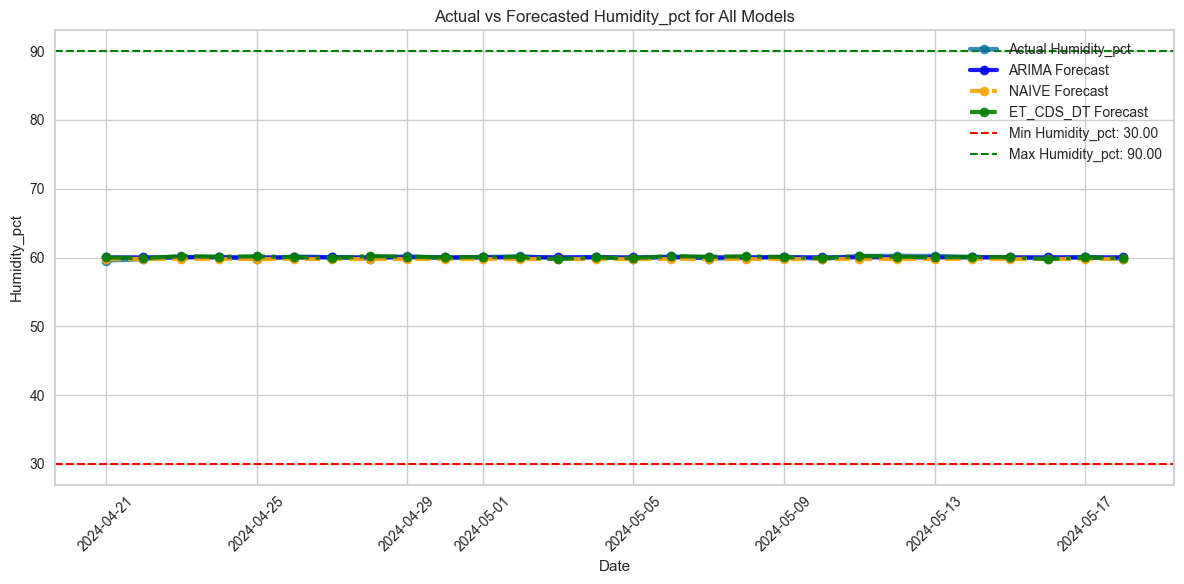

In [137]:
filePath = 'weather_data.csv'
temperatureForecasts = runForecastPipeline(
    filePath, 
    'Temperature_C', 
    'Temperature (°C)', 
    minValue=-19.97, 
    maxValue=40
)
humidityForecasts = runForecastPipeline(
    filePath, 
    'Humidity_pct', 
    'Humidity (%)', 
    minValue=30, 
    maxValue=90
)